# Imports

Link for the dataset - [Task3](https://www.kaggle.com/datasets/enesumcu/car-and-truck)

In [ ]:
import os, cv2
import numpy as np
import tensorflow as tf
from tensorflow.python import keras

from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, AvgPool2D
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.optimizers import SGD
from keras.layers import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array, array_to_img, load_img
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [ ]:
data_dir = '../input/datasets/Datasets/'

images = []
car_types = []

for car_type in ["car","truck"]:
    car_dir = data_dir + car_type
    car_files = [car_dir + '/' + filename for filename in os.listdir(car_dir)]
    #print(car_files)
    for filename in car_files:
        if filename.endswith('jpg'):
            try:
                images.append(cv2.resize(cv2.imread(filename), (224,224), interpolation=cv2.INTER_CUBIC))
                car_types.append(car_type)
            except Exception as e:
                print(str(e))
            
            
images = np.array(images)
car_types = np.array(car_types)

le = LabelEncoder()
car_types_encoded = le.fit_transform(car_types)
car_types_encoded_onehot = np_utils.to_categorical(car_types_encoded)

OpenCV(3.4.3) /io/opencv/modules/imgproc/src/resize.cpp:4044: error: (-215:Assertion failed) !ssize.empty() in function 'resize'



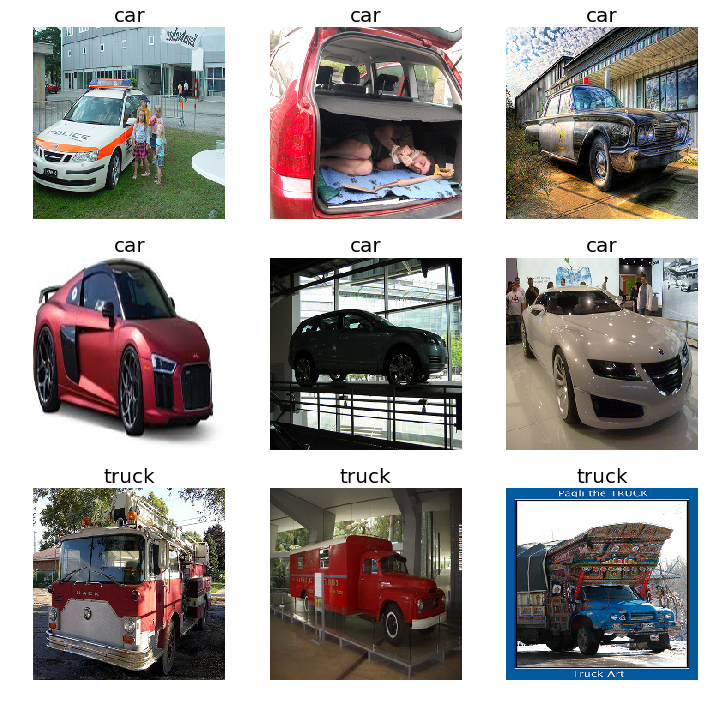

In [ ]:
_, ax = plt.subplots(3,3, figsize=(12,12))
for i in range(3):
    for j in range(3):
      ax[i,j].imshow(cv2.cvtColor(images[(i*300)+j], cv2.COLOR_BGR2RGB))
      ax[i,j].axis('off')
      ax[i,j].set_title(le.inverse_transform(car_types_encoded[(i*300)+j]), size = 20)

In [ ]:
images, car_types, car_types_encoded = shuffle(images, car_types, car_types_encoded)
car_types_encoded.resize((images.shape[0],1))
print(car_types_encoded.shape)

(788, 1)


# Augumented data

In [ ]:
car_types_encoded = car_types_encoded.reshape((images.shape[0],1))
car_types_2class = np.zeros((images.shape[0],2))
for i in range(images.shape[0]):
    if car_types_encoded[i][0] == 0:
        car_types_2class[i][0] = 1
    else:
        car_types_2class[i][1] = 1
#print(car_types_2class[1:100,:])
x_train, x_val, y_train, y_val = train_test_split(images, car_types_2class, test_size=0.2, random_state=0)
x_train = x_train / 255
x_val = x_val / 255

# set train Generator
datagen = ImageDataGenerator(rotation_range=30,width_shift_range=0.2,height_shift_range=0.2,horizontal_flip=True)
datagen.fit(x_train)


## CNN

In [ ]:
model = Sequential()

model.add(Conv2D(32, (3, 3),input_shape=(224, 224, 3),strides = (1,1),  padding = 'same',kernel_initializer='he_normal', activation='relu'))
model.add(BatchNormalization())
model.add(AvgPool2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3),strides = (1,1),  padding = 'same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3),strides = (1,1),  padding = 'same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3),strides = (1,1),  padding = 'same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(units=128, activation='relu', kernel_initializer='normal'))
model.add(Dense(units=2, activation='sigmoid', kernel_initializer='normal'))

model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_71 (Conv2D)           (None, 224, 224, 32)      896       
_________________________________________________________________
batch_normalization_13 (Batc (None, 224, 224, 32)      128       
_________________________________________________________________
average_pooling2d_13 (Averag (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_72 (Conv2D)           (None, 112, 112, 32)      9248      
_________________________________________________________________
max_pooling2d_56 (MaxPooling (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_73 (Conv2D)           (None, 56, 56, 32)        9248      
_________________________________________________________________
max_pooling2d_57 (MaxPooling (None, 28, 28, 32)        0         
__________

In [ ]:
# trainning process
nb_epoch = 40
batch_size = 4

fitted_model = model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                    steps_per_epoch = x_train.shape[0],
                    epochs=nb_epoch,
                    validation_data = (x_val, y_val)
                    )


Epoch 1/40
630/630 [==============================] - 27s 43ms/step - loss: 0.6818 - acc: 0.5698 - val_loss: 0.7169 - val_acc: 0.5158
Epoch 2/40
630/630 [==============================] - 25s 40ms/step - loss: 0.6626 - acc: 0.5984 - val_loss: 0.6668 - val_acc: 0.5285
Epoch 3/40
630/630 [==============================] - 27s 42ms/step - loss: 0.6372 - acc: 0.6349 - val_loss: 0.6352 - val_acc: 0.6582
Epoch 4/40
630/630 [==============================] - 27s 43ms/step - loss: 0.6241 - acc: 0.6387 - val_loss: 0.6456 - val_acc: 0.6203
Epoch 5/40
630/630 [==============================] - 27s 42ms/step - loss: 0.6138 - acc: 0.6476 - val_loss: 0.6411 - val_acc: 0.6741
Epoch 6/40
630/630 [==============================] - 27s 43ms/step - loss: 0.6006 - acc: 0.6698 - val_loss: 0.6307 - val_acc: 0.6519
Epoch 7/40
630/630 [==============================] - 26s 42ms/step - loss: 0.6005 - acc: 0.6629 - val_loss: 0.6595 - val_acc: 0.6899
Epoch 8/40
630/630 [==============================] - 26s 41ms

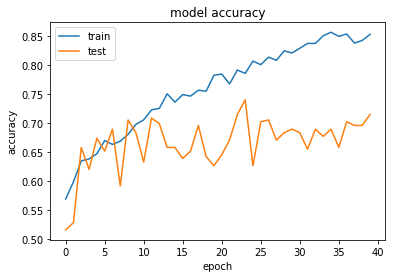

In [ ]:
plt.plot(fitted_model.history['acc'])
plt.plot(fitted_model.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

plt.show()

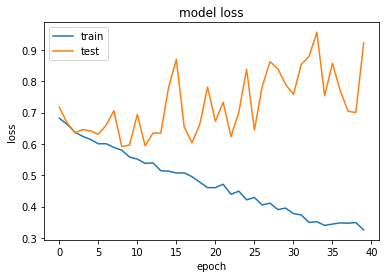

In [ ]:
plt.figure()
plt.gcf().clear()
plt.plot(fitted_model.history['loss'])
plt.plot(fitted_model.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

plt.show()

## Resnet

In [ ]:
from keras.applications.resnet50 import ResNet50 

def build_ResNet50(input_tensor_shape):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape= input_tensor_shape)
    
    x_model = base_model.output
    
    x_model = AvgPool2D(name='globalaveragepooling2d')(x_model)
    
    x_model = Dense(1024, activation='relu',name='fc1_Dense')(x_model)
    x_model = Dropout(0.5, name='dropout_1')(x_model)
    x_model = Flatten()(x_model)
    x_model = Dense(256, activation='relu',name='fc2_Dense')(x_model)
    x_model = Dropout(0.5, name='dropout_2')(x_model)
    
    predictions = Dense(2, activation='sigmoid',name='output_layer')(x_model)
    
    model = Model(inputs=base_model.input, outputs=predictions)
    
    return model



input_tensor_shape = (224,224,3)

model2 = build_ResNet50(input_tensor_shape)

model2.summary()
model2.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='binary_crossentropy', metrics=['accuracy'])

94658560/94653016 [==============================] - 4s 0us/step
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
____________________________________________

In [ ]:

# trainning process
nb_epoch = 5
batch_size = 4
fitted_model2 = model2.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                    steps_per_epoch = x_train.shape[0],
                    epochs=nb_epoch,
                    validation_data = (x_val, y_val),
                    )


Epoch 1/5
630/630 [==============================] - 57s 90ms/step - loss: 0.6800 - acc: 0.6671 - val_loss: 0.2722 - val_acc: 0.8924
Epoch 2/5
630/630 [==============================] - 47s 74ms/step - loss: 0.4029 - acc: 0.8139 - val_loss: 0.1795 - val_acc: 0.9399
Epoch 3/5
630/630 [==============================] - 47s 75ms/step - loss: 0.3157 - acc: 0.8669 - val_loss: 0.1975 - val_acc: 0.9146
Epoch 4/5
630/630 [==============================] - 46s 73ms/step - loss: 0.2576 - acc: 0.8917 - val_loss: 0.1892 - val_acc: 0.9335
Epoch 5/5
630/630 [==============================] - 47s 75ms/step - loss: 0.1777 - acc: 0.9268 - val_loss: 0.1927 - val_acc: 0.9304


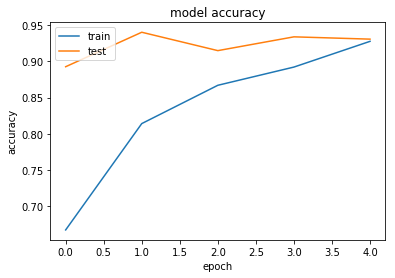

In [ ]:
plt.plot(fitted_model2.history['acc'])
plt.plot(fitted_model2.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

plt.show()

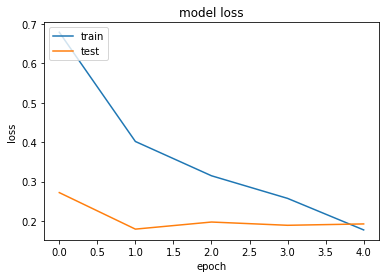

In [ ]:
plt.figure()
plt.gcf().clear()
plt.plot(fitted_model2.history['loss'])
plt.plot(fitted_model2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

plt.show()

# Without augumentation

In [ ]:
car_types_encoded = car_types_encoded.reshape((images.shape[0],1))
car_types_2class = np.zeros((images.shape[0],2))
for i in range(images.shape[0]):
    if car_types_encoded[i][0] == 0:
        car_types_2class[i][0] = 1
    else:
        car_types_2class[i][1] = 1

x_train, x_val, y_train, y_val = train_test_split(images, car_types_2class, test_size=0.2, random_state=0)
x_train = x_train / 255
x_val = x_val / 255

datagen = ImageDataGenerator()
datagen.fit(x_train)


## CNN

In [ ]:
model1 = Sequential()

model1.add(Conv2D(32, (3, 3),input_shape=(224, 224, 3),strides = (1,1),  padding = 'same',kernel_initializer='he_normal', activation='relu'))
model1.add(BatchNormalization())
model1.add(AvgPool2D(pool_size=(2, 2)))

model1.add(Conv2D(32, (3, 3),strides = (1,1),  padding = 'same', activation='relu'))
model1.add(MaxPooling2D(pool_size=(2, 2)))

model1.add(Conv2D(32, (3, 3),strides = (1,1),  padding = 'same', activation='relu'))
model1.add(MaxPooling2D(pool_size=(2, 2)))

model1.add(Conv2D(32, (3, 3),strides = (1,1),  padding = 'same', activation='relu'))
model1.add(MaxPooling2D(pool_size=(2, 2)))

model1.add(Flatten())
model1.add(Dense(units=128, activation='relu', kernel_initializer='normal'))
model1.add(Dense(units=2, activation='sigmoid', kernel_initializer='normal'))

model1.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
model1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_83 (Conv2D)           (None, 224, 224, 32)      896       
_________________________________________________________________
batch_normalization_16 (Batc (None, 224, 224, 32)      128       
_________________________________________________________________
average_pooling2d_16 (Averag (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_84 (Conv2D)           (None, 112, 112, 32)      9248      
_________________________________________________________________
max_pooling2d_65 (MaxPooling (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_85 (Conv2D)           (None, 56, 56, 32)        9248      
_________________________________________________________________
max_pooling2d_66 (MaxPooling (None, 28, 28, 32)        0         
__________

In [ ]:
# trainning process
nb_epoch = 40
batch_size = 4
from keras.callbacks import ModelCheckpoint, EarlyStopping
er_cb = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=7)
fitted_model1 = model1.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                    steps_per_epoch = x_train.shape[0],
                    epochs=nb_epoch,
                    validation_data = (x_val, y_val)
                   ,callbacks=[er_cb]
                    )

Epoch 1/40
630/630 [==============================] - 8s 13ms/step - loss: 0.3443 - acc: 0.8381 - val_loss: 1.8253 - val_acc: 0.6297
Epoch 2/40
630/630 [==============================] - 8s 12ms/step - loss: 0.0537 - acc: 0.9812 - val_loss: 2.2864 - val_acc: 0.6171
Epoch 3/40
630/630 [==============================] - 8s 12ms/step - loss: 2.7229e-04 - acc: 1.0000 - val_loss: 2.6309 - val_acc: 0.6203
Epoch 4/40
630/630 [==============================] - 8s 13ms/step - loss: 1.0546e-04 - acc: 1.0000 - val_loss: 2.8018 - val_acc: 0.6139
Epoch 5/40
630/630 [==============================] - 8s 13ms/step - loss: 5.1283e-05 - acc: 1.0000 - val_loss: 2.9369 - val_acc: 0.6139
Epoch 6/40
630/630 [==============================] - 8s 12ms/step - loss: 4.5656e-05 - acc: 1.0000 - val_loss: 3.0742 - val_acc: 0.6266
Epoch 7/40
630/630 [==============================] - 8s 12ms/step - loss: 1.3643e-05 - acc: 1.0000 - val_loss: 3.1583 - val_acc: 0.6234
Epoch 8/40
630/630 [=============================

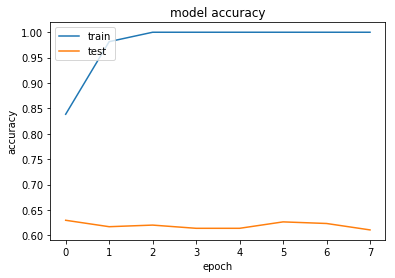

In [ ]:
plt.plot(fitted_model1.history['acc'])
plt.plot(fitted_model1.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

plt.show()

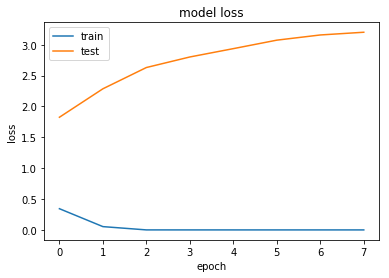

In [ ]:
plt.figure()
plt.gcf().clear()
plt.plot(fitted_model1.history['loss'])
plt.plot(fitted_model1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

plt.show()

## Resnet 

In [ ]:
input_tensor_shape = (224,224,3)

model3 = build_ResNet50(input_tensor_shape)

model3.summary()
model3.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='binary_crossentropy', metrics=['accuracy'])

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [ ]:

# trainning process
nb_epoch = 5
batch_size = 4
fitted_model3 = model3.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                    steps_per_epoch = x_train.shape[0],
                    epochs=nb_epoch,
                    validation_data = (x_val, y_val),
                    )


Epoch 1/5
630/630 [==============================] - 53s 84ms/step - loss: 0.5214 - acc: 0.7593 - val_loss: 0.2511 - val_acc: 0.9082
Epoch 2/5
630/630 [==============================] - 43s 68ms/step - loss: 0.1676 - acc: 0.9361 - val_loss: 0.2495 - val_acc: 0.9177
Epoch 3/5
630/630 [==============================] - 43s 68ms/step - loss: 0.0818 - acc: 0.9698 - val_loss: 0.2922 - val_acc: 0.8892
Epoch 4/5
630/630 [==============================] - 43s 68ms/step - loss: 0.0353 - acc: 0.9885 - val_loss: 0.2923 - val_acc: 0.9114
Epoch 5/5
630/630 [==============================] - 43s 68ms/step - loss: 0.0211 - acc: 0.9935 - val_loss: 0.3090 - val_acc: 0.9051


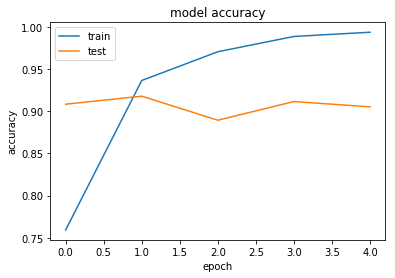

In [ ]:
plt.plot(fitted_model3.history['acc'])
plt.plot(fitted_model3.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

plt.show()

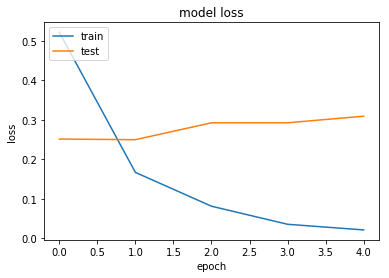

In [ ]:
plt.figure()
plt.gcf().clear()
plt.plot(fitted_model3.history['loss'])
plt.plot(fitted_model3.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

plt.show()